I used this notebook for:
 1) converting file types, txt csv vtk etc
 2) trying different methods for forming input/output pairs for the models 
 3) random operations

 Overall alot of the cells won't make sense but I am keeping them here incase they are useful to me later

**Imports**

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import csv
import math
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten, Reshape, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.constraints import MinMaxNorm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import vtk

**CUDA**

In [2]:
len(tf.config.list_physical_devices('GPU'))>0

True

**Convert .txt to .csv**

In [ ]:
input_folder = "C:/Users/Ioannis/Documents/UvA thesis/UvA-thesis/data/concentrations_txt/S8"
output_folder = "C:/Users/Ioannis/Documents/UvA thesis/UvA-thesis/data/concentrations/S8"

# create output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# iterate through files in input folder
for filename in os.listdir(input_folder):
    if filename.endswith(".txt"):
        try:
            # construct input and output file paths
            input_filepath = os.path.join(input_folder, filename)
            output_filepath = os.path.join(output_folder, os.path.splitext(filename)[0] + ".csv")

            # read txt file and remove leading and trailing quotation marks from each line
            with open(input_filepath, 'r') as file:
                lines = [line.strip().strip('"') for line in file.readlines()]

            # convert to df and save as csv
            df = pd.DataFrame([line.split(',') for line in lines])
            df.to_csv(output_filepath, index=False, header=False, quoting=csv.QUOTE_NONE, escapechar=' ')
            print(f"Converted {input_filepath} to {output_filepath}")
        except Exception as e:
            print(f"Error converting {input_filepath}: {e}")


**Merge data in batches to create the 'merged_data' folder containing all the available data**

In [ ]:
cellcounts_folder = 'C:/Users/Ioannis/Documents/UvA thesis/UvA-thesis/data/cellcounts'
base_cytokine_folder = 'C:/Users/Ioannis/Documents/UvA thesis/UvA-thesis/data/concentrations'
output_folder = 'C:/Users/Ioannis/Documents/UvA thesis/UvA-thesis/data/merged_data'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

cellcounts_batch_size = 8
cytokine_batch_size = 101

for batch_index in range(1, cellcounts_batch_size + 1):
    print(f"Processing batch {batch_index}")
    cellcounts_file = os.path.join(cellcounts_folder, f'cellcount S{batch_index}.csv')
    print("Cellcounts file:", cellcounts_file)
    cytokine_subfolder = f'S{batch_index}'
    cytokine_folder = os.path.join(base_cytokine_folder, cytokine_subfolder)
    df_cellcounts_batch = pd.read_csv(cellcounts_file)
    print("Cellcounts batch shape:", df_cellcounts_batch.shape)
    df_cytokine_batch = pd.DataFrame()
    for cytokine_file in os.listdir(cytokine_folder):
        if cytokine_file.endswith('.csv'):
            file_path = os.path.join(cytokine_folder, cytokine_file)
            df_cytokine = pd.read_csv(file_path)
            df_cytokine_batch = pd.concat([df_cytokine_batch, df_cytokine], ignore_index=True)

    print("Cytokine batch shape:", df_cytokine_batch.shape)

    merged_data = pd.merge(df_cellcounts_batch, df_cytokine_batch, on='mcsteps')
    print("Merged data shape:", merged_data.shape)

    output_filename = os.path.join(output_folder, f'combined_data_batch_{batch_index}.csv')
    merged_data.to_csv(output_filename, index=False)
    print(f"Saved merged data to {output_filename}")

**Concat the cytokines data to create the 'all_data' folder**

In [5]:
base_cytokine_folder = 'C:/Users/Ioannis/Documents/UvA thesis/UvA-thesis/data/concentrations'
output_folder = 'C:/Users/Ioannis/Documents/UvA thesis/UvA-thesis/data/all_data'

def create_simulation_subfolders(output_folder, simulation_names):
    for sim_name in simulation_names:
        sim_folder = os.path.join(output_folder, sim_name)
        os.makedirs(sim_folder, exist_ok=True)


def concat_files_in_folder(folder_path):
    all_data = pd.DataFrame()
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            all_data = pd.concat([all_data, df])
    return all_data

def sort_by_mcsteps(data):
    return data.sort_values(by='mcsteps')

simulation_names = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8']
create_simulation_subfolders(output_folder, simulation_names)

for sim_name in simulation_names:
    sim_folder_path = os.path.join(output_folder, sim_name)
    sim_data = concat_files_in_folder(os.path.join(base_cytokine_folder, sim_name))
    sorted_data = sort_by_mcsteps(sim_data)
    output_file_path = os.path.join(sim_folder_path, f'{sim_name}_data_sorted.csv')
    sorted_data.to_csv(output_file_path, index=False)

**Load data to cover all initializations (df1 to df8) and drop zCOM column as we have 2D spatial data**

In [4]:
output_folder = "C:/Users/Ioannis/Documents/UvA thesis/UvA-thesis/data/all_data"

def load_and_drop_zCOM(folder_path):
    df = pd.concat([pd.read_csv(os.path.join(folder_path, file)) for file in os.listdir(folder_path) if file.endswith('.csv')])
    df.drop(columns=['zCOM'], inplace=True)
    return df

dfs = []
for i in range(1, 9):
    sim_folder_path = os.path.join(output_folder, f'S{i}')
    df = load_and_drop_zCOM(sim_folder_path)
    dfs.append(df)

df1, df2, df3, df4, df5, df6, df7, df8 = dfs

**Change 'mcsteps' to 'time' and print dataframe to make sure it works as intended**

In [5]:
df8['time'] = (df8['mcsteps'] / 10000).astype(int)
df8 = df8[['time'] + [col for col in df8.columns if col != 'time']]
df8.drop(columns=['mcsteps'], inplace=True)
print(df8)

        time  xCOM  yCOM           il8           il1           il6  \
0          0   147   116  8.603181e-10  0.000000e+00  0.000000e+00   
1          0   251   364  9.141505e-10  0.000000e+00  0.000000e+00   
2          0   279   112  9.350631e-10  0.000000e+00  0.000000e+00   
3          0    83   288  9.888261e-10  0.000000e+00  0.000000e+00   
4          0   171   371  1.105985e-09  0.000000e+00  0.000000e+00   
...      ...   ...   ...           ...           ...           ...   
569270   100   172   192  1.493359e-08  1.195303e-11  3.136481e-27   
569271   100   141   107  1.232809e-08  1.575511e-11  3.546226e-15   
569272   100    81   257  1.258248e-08  1.729580e-11  1.002741e-11   
569273   100   127   264  1.046952e-08  9.687031e-12  1.480615e-14   
569274   100   298   363  1.142387e-08  7.674055e-12  5.401783e-25   

                il10           tnf           tgf  
0       0.000000e+00  0.000000e+00  0.000000e+00  
1       0.000000e+00  0.000000e+00  0.000000e+00  
2     

C:\Users\Ioannis\AppData\Local\Temp\ipykernel_10104\2445232496.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df8.drop(columns=['mcsteps'], inplace=True)


In [6]:
# Select columns containing cytokine data
cytokine_columns = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']

# Find the smallest values for each cytokine
smallest_values = df8[cytokine_columns].min()

# Find the largest values for each cytokine
largest_values = df8[cytokine_columns].max()

print("Smallest values for each cytokine:")
print(smallest_values)

print("\nLargest values for each cytokine:")
print(largest_values)

Smallest values for each cytokine:
il8    -1.802096e-11
il1     0.000000e+00
il6     0.000000e+00
il10    0.000000e+00
tnf     0.000000e+00
tgf     0.000000e+00
dtype: float64

Largest values for each cytokine:
il8     1.817857e-08
il1     7.833237e-09
il6     6.361151e-09
il10    1.409022e-09
tnf     5.365540e-08
tgf     1.111927e-08
dtype: float64


**Create an array for each unique mcsteps value, should taken a couple minutes to run**

In [5]:
# define cytokines
cytokines = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']

# get unique time values
unique_time = df8['time'].unique()

arrays = {}

# iterate over unique time values
for time in unique_time:
    # filter data for current value of time
    df_time = df8[df8['time'] == time]
    
    # initialize 500x500 array for current value of time
    array = np.zeros((500, 500, len(cytokines)))
    
    # iterate over rows in filtered df
    for index, row in df_time.iterrows():
        # get X and Y coordinates
        x = int(row['xCOM'])
        y = int(row['yCOM'])
        
        # get cytokine concentrations
        concentrations = row[['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']].values
        
        # assign cytokine concentrations to corresponding position in array
        array[x, y] = concentrations
    
    # store array for current value of time
    arrays[time] = array

**Print to make sure array works as intended**

In [6]:
print("Number of arrays:", len(arrays))
array = arrays[100]
print("Shape of the array:", array.shape)
print("Value at position (356,200):", array[356,200])

Number of arrays: 101
Shape of the array: (500, 500, 6)
Value at position (356,200): [1.1378244e-08 2.0458439e-11 5.3863960e-15 5.2224680e-23 7.6039260e-18
 1.2120631e-11]


**Create input_sequences and output_values for the LSTM to use in order to be able to predict output_values from input_sequences**

In [18]:
sequence_length = 10
input_sequences = []
output_values = []

# convert dictionary values to a list of arrays
arrays_list = [arrays[key] for key in sorted(arrays.keys())]

# convert 'arrays' list to numpy array
arrays_np = np.array(arrays_list)

for i in range(len(arrays_np) - sequence_length):
    input_seq = arrays_np[i:i+sequence_length]  # input sequence of arrays
    output_val = arrays_np[i+sequence_length]   # array at next time step
    
    input_sequences.append(input_seq)
    output_values.append(output_val)

# convert lists to numpy arrays
input_sequences = np.array(input_sequences)
output_values = np.array(output_values)

**input_sequences has a shape of (91, 10, 500, 500, 6), which means we have 91 samples, each consisting of 10 arrays of shape (500, 500, 6).**

**output_values has a shape of (91, 500, 500, 6), indicating that each sample has an output array of shape (500, 500, 6).**

In [ ]:
print(input_sequences.shape)
print(output_values.shape)

csv to vtk

In [16]:
import pandas as pd
import vtk
import os

def csv_to_vtk_per_timestep(csv_file, output_dir):
    try:
        df = pd.read_csv(csv_file)

        required_columns = ['timestep', 'X', 'Y']
        if not all(column in df.columns for column in required_columns):
            raise ValueError(f"CSV file must contain columns: {', '.join(required_columns)}")

        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        timesteps = df['timestep'].unique()
        feature_names = [col for col in df.columns if col not in ['timestep', 'X', 'Y']]

        for timestep in timesteps:
            timestep_df = df[df['timestep'] == timestep]

            # Create VTK StructuredPoints object
            structured_points = vtk.vtkStructuredPoints()
            structured_points.SetDimensions(100, 100, 1)  # Assuming 50x50 grid
            structured_points.SetSpacing(1, 1, 1)
            structured_points.SetOrigin(0, 0, 0)

            # Add point data (features)
            point_data = structured_points.GetPointData()
            for feature in feature_names:
                feature_array = vtk.vtkFloatArray()
                feature_array.SetName(feature)
                feature_array.SetNumberOfComponents(1)
                feature_array.SetNumberOfTuples(100 * 100)  # Assuming 50x50 grid

                for index, value in enumerate(timestep_df[feature]):
                    feature_array.SetValue(index, value)

                point_data.AddArray(feature_array)

            # Write the data to a VTK file
            vtk_file_path = os.path.join(output_dir, f"timestep_{timestep}.vtk")
            writer = vtk.vtkStructuredPointsWriter()
            writer.SetFileName(vtk_file_path)
            writer.SetInputData(structured_points)
            writer.Write()
            print(f"Successfully wrote {vtk_file_path}")

    except Exception as e:
        print(f"An error occurred: {e}")

# Usage
csv_file_path = "C:/Users/Ioannis/Documents/UvA thesis/UvA-thesis/data/LSTM(100x100)(72-100).csv"
output_dir = "C:/Users/Ioannis/Documents/UvA thesis/UvA-thesis/data/vtk_outputs(100x100)/vtk_outputs(LSTM 72-100)"
csv_to_vtk_per_timestep(csv_file_path, output_dir)

Successfully wrote C:/Users/Ioannis/Documents/UvA thesis/UvA-thesis/data/vtk_outputs(100x100)/vtk_outputs(LSTM 72-100)\timestep_72.vtk
Successfully wrote C:/Users/Ioannis/Documents/UvA thesis/UvA-thesis/data/vtk_outputs(100x100)/vtk_outputs(LSTM 72-100)\timestep_73.vtk
Successfully wrote C:/Users/Ioannis/Documents/UvA thesis/UvA-thesis/data/vtk_outputs(100x100)/vtk_outputs(LSTM 72-100)\timestep_74.vtk
Successfully wrote C:/Users/Ioannis/Documents/UvA thesis/UvA-thesis/data/vtk_outputs(100x100)/vtk_outputs(LSTM 72-100)\timestep_75.vtk
Successfully wrote C:/Users/Ioannis/Documents/UvA thesis/UvA-thesis/data/vtk_outputs(100x100)/vtk_outputs(LSTM 72-100)\timestep_76.vtk
Successfully wrote C:/Users/Ioannis/Documents/UvA thesis/UvA-thesis/data/vtk_outputs(100x100)/vtk_outputs(LSTM 72-100)\timestep_77.vtk
Successfully wrote C:/Users/Ioannis/Documents/UvA thesis/UvA-thesis/data/vtk_outputs(100x100)/vtk_outputs(LSTM 72-100)\timestep_78.vtk
Successfully wrote C:/Users/Ioannis/Documents/UvA thesi

In [57]:
def filter_timesteps(csv_file, output_file, max_timestep=10):
    try:
        # Read the CSV file
        df = pd.read_csv(csv_file)

        # Filter out rows with timestep >= max_timestep
        filtered_df = df[df['timestep'] < max_timestep]

        # Save the filtered DataFrame to a new CSV file
        filtered_df.to_csv(output_file, index=False)
        print(f"Successfully wrote filtered data to {output_file}")

    except Exception as e:
        print(f"An error occurred: {e}")

# Usage
csv_file_path = "C:/Users/Ioannis/Documents/UvA thesis/UvA-thesis/data/PINN(100x100)(72-89hrs).csv"
output_file_path = "C:/Users/Ioannis/Documents/UvA thesis/UvA-thesis/data/filtered_data.csv"
filter_timesteps(csv_file_path, output_file_path)

Successfully wrote filtered data to C:/Users/Ioannis/Documents/UvA thesis/UvA-thesis/data/filtered_data.csv


In [58]:
def merge_and_rename_timesteps(filtered_file, new_file, output_file):

    try:
    
        df_filtered = pd.read_csv(filtered_file)
        df_new = pd.read_csv(new_file)

        
        df_filtered['timestep'] = df_filtered['timestep'] + 72
        df_new['timestep'] = df_new['timestep'] + 82

        merged_df = pd.concat([df_filtered, df_new], ignore_index=True)

      
        merged_df.to_csv(output_file, index=False)
        print(f"Successfully wrote merged data to {output_file}")

    except Exception as e:
        print(f"An error occurred: {e}")

# Usage
filtered_file_path = "C:/Users/Ioannis/Documents/UvA thesis/UvA-thesis/data/filtered_data.csv"
new_file_path = "C:/Users/Ioannis/Documents/UvA thesis/UvA-thesis/data/PINN(100x100)(82-100hrs).csv"
output_file_path = "C:/Users/Ioannis/Documents/UvA thesis/UvA-thesis/data/PINN(100x100)(72-100).csv"
merge_and_rename_timesteps(filtered_file_path, new_file_path, output_file_path)

Successfully wrote merged data to C:/Users/Ioannis/Documents/UvA thesis/UvA-thesis/data/PINN(100x100)(72-100).csv


C:\Users\Ioannis\AppData\Local\Temp\ipykernel_12696\1907116905.py:69: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_color('#505050')  # A grey color for the ticks


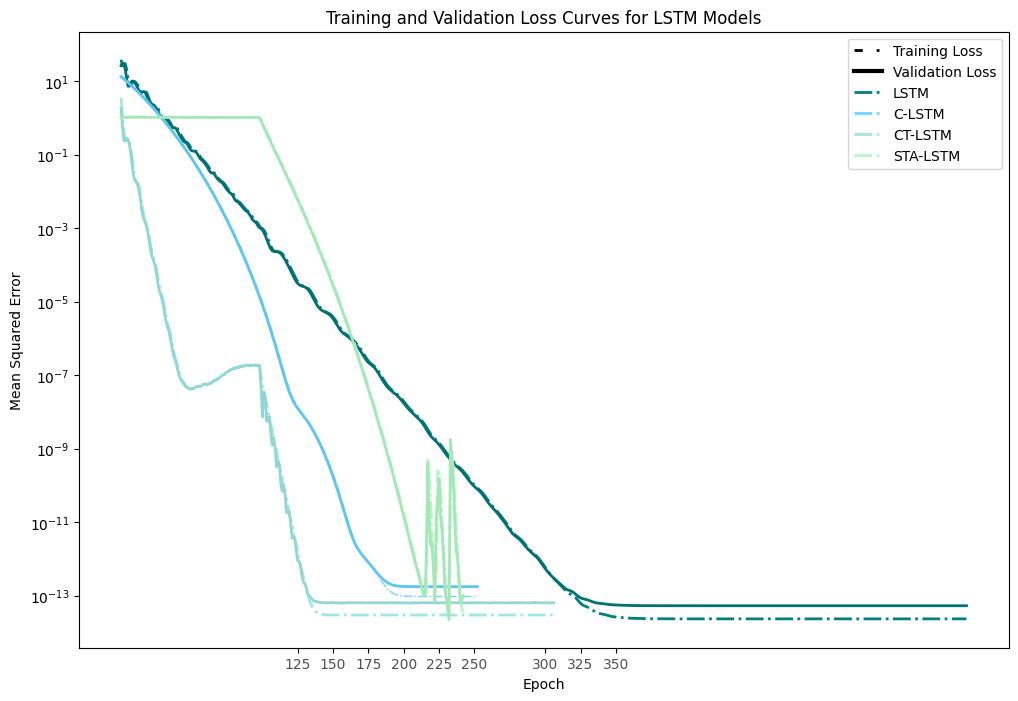

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV files
network1 = pd.read_csv('plots(50x50)/plots-LSTM/LSTM-loss_data.csv')
network2 = pd.read_csv('plots(50x50)/plots-C-LSTM/C-LSTM-loss_data.csv')
network3 = pd.read_csv('plots(50x50)/plots-CT-LSTM/CT-LSTM-loss_data.csv')
network4 = pd.read_csv('plots(50x50)/plots-STA-LSTM/STA-LSTM-loss_data.csv')

# Extract the columns for training and validation loss
train_loss1 = network1['Training Loss']
val_loss1 = network1['Validation Loss']
train_loss2 = network2['Training Loss']
val_loss2 = network2['Validation Loss']
train_loss3 = network3['Training Loss']
val_loss3 = network3['Validation Loss']
train_loss4 = network4['Training Loss']
val_loss4 = network4['Validation Loss']

# Define the colors
train_colors = ['#008080', '#70D6FF', '#A0E7E5', '#B4F8C8']
val_colors = ['#007070', '#60C6EF', '#90D7D5', '#A4E8B8']  # Slightly adjusted colors

# Plot the data
plt.figure(figsize=(12, 8))
# Custom dashed pattern
dashed_pattern = (0, (3, 5, 1, 5))
# Plot network 1
plt.plot(train_loss1, label='LSTM - Train Loss', color=train_colors[0], linestyle='-.', linewidth=2)
plt.plot(val_loss1, label='LSTM - Validation Loss', color=val_colors[0], linewidth=2)

# Plot network 2
plt.plot(train_loss2, label='C-LSTM - Train Loss', color=train_colors[1], linestyle='-.', linewidth=1)
plt.plot(val_loss2, label='C-LSTM - Validation Loss', color=val_colors[1], linewidth=2)

# Plot network 3
plt.plot(train_loss3, label='CT-LSTM - Train Loss', color=train_colors[2], linestyle='-.', linewidth=2)
plt.plot(val_loss3, label='CT-LSTM - Validation Loss', color=val_colors[2], linewidth=2)

# Plot network 4
plt.plot(train_loss4, label='STA-LSTM - Train Loss', color=train_colors[3], linestyle='-.', linewidth=2)
plt.plot(val_loss4, label='STA-LSTM - Validation Loss', color=val_colors[3], linewidth=2)

# Add labels, title, and legend
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.yscale('log')
plt.title('Training and Validation Loss Curves for LSTM Models')


# Custom legend
custom_lines = [
    plt.Line2D([0], [0], color='black', linestyle=dashed_pattern, linewidth=2, label='Training Loss'),
    plt.Line2D([0], [0], color='black', linestyle='-', linewidth=3, label='Validation Loss'),
    plt.Line2D([0], [0], color=train_colors[0], linestyle='-.', linewidth=2, label='LSTM'),
    plt.Line2D([0], [0], color=train_colors[1], linestyle='-.', linewidth=2, label='C-LSTM'),
    plt.Line2D([0], [0], color=train_colors[2], linestyle='-.', linewidth=2, label='CT-LSTM'),
    plt.Line2D([0], [0], color=train_colors[3], linestyle='-.', linewidth=2, label='STA-LSTM')
]

plt.legend(handles=custom_lines, loc='upper right')

# Adjust xticks
xticks = list(range(125, 251, 25)) + list(range(300, 351, 25))
plt.xticks(xticks)

# Adjust xticks color slightly
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_color('#505050')  # A grey color for the ticks

plt.show()

C:\Users\Ioannis\AppData\Local\Temp\ipykernel_12696\1913069468.py:22: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, data[cytokine].max())


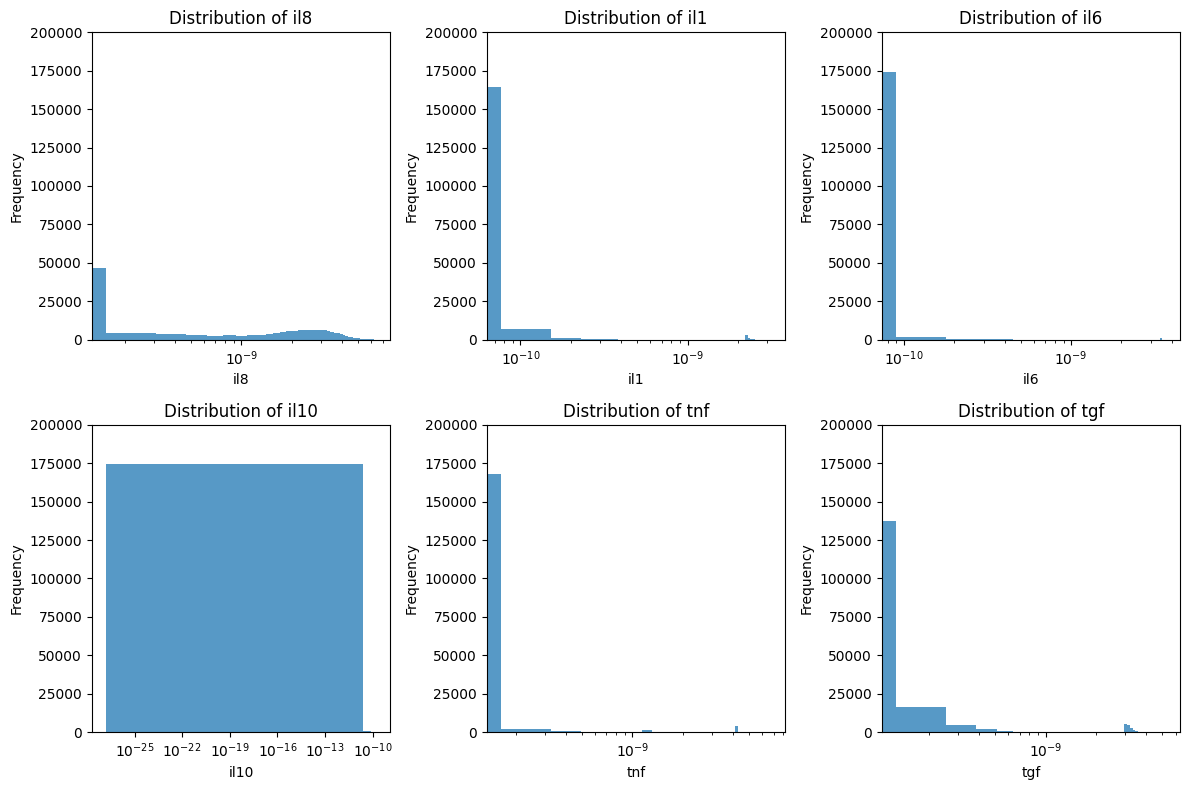

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the specified file
file_path = "C:/Users/Ioannis/Documents/UvA thesis/UvA-thesis/data/test_data_concat/final run concat 500x500.csv"
data = pd.read_csv(file_path)

# Extract cytokine columns
cytokines = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']

# Convert string representations of lists to float
data[cytokines] = data[cytokines].applymap(lambda x: float(x.strip('[]')))

# Plot the distribution of each cytokine
plt.figure(figsize=(12, 8))
for i, cytokine in enumerate(cytokines):
    plt.subplot(2, 3, i + 1)
    plt.hist(data[cytokine], bins=50, alpha=0.75)
    plt.title(f'Distribution of {cytokine}')
    plt.xlabel(f'{cytokine}')
    plt.xscale('log')
    plt.xlim(0, data[cytokine].max())
    plt.ylim(0, 200000)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()